In [13]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime

In [27]:
df = pd.read_csv('../data/unlock-the-box-data.csv', parse_dates=['start_date', 'end_date'])
print(df.dtypes)

start_date       datetime64[ns]
end_date         datetime64[ns]
reasons                  object
gender                   object
ethnicity                object
age                       int64
facility_id               int64
facility_name            object
facility_type            object
dtype: object


In [9]:
rsns = df.reasons.unique().tolist()

In [28]:
strlist = "[a, b]"

def str_to_list(x):
    return x.strip('[]').replace("'", "").split(', ')

#print(str_to_list(strlist))
rsns_unq = np.unique(sum([str_to_list(x) for x in rsns], [])).tolist()
rsns_unq

['COVID-19',
 'Disciplinary sanctions',
 'Inmate is a threat or danger to the safety and security of the facility',
 'Inmate is threat to others',
 'Medical and mental health hold',
 'Other']

In [29]:
rsns_short = ['covid', 'disciplinary', 'threat_facility', 'threat_others', 'medical', 'other']

for rsn in range(len(rsns_unq)): 
    df[f'rsn_{rsns_short[rsn]}_ind'] = df.reasons.str.contains(rsns_unq[rsn]).replace({True: 1, False: 0})
 
df['duration_days'] = (df.end_date - df.start_date).dt.days

df.head(5)

,start_date,end_date,reasons,gender,ethnicity,age,facility_id,facility_name,facility_type,rsn_covid_ind,rsn_disciplinary_ind,rsn_threat_facility_ind,rsn_threat_others_ind,rsn_medical_ind,rsn_other_ind,duration_days
0,2020-11-29,NaT,['Disciplinary sanctions'],Male,Hispanic,35,18,Metropolitan Detention Center,Jail,0,1,0,0,0,0,NaN
1,2022-03-31,2022-04-04,['Other'],Female,Asian,21,18,Metropolitan Detention Center,Jail,0,0,0,0,0,1,4.0
2,2022-03-31,NaT,['Disciplinary sanctions'],Male,Hispanic,29,18,Metropolitan Detention Center,Jail,0,1,0,0,0,0,NaN
3,2022-03-31,NaT,['Disciplinary sanctions'],Male,Hispanic,33,18,Metropolitan Detention Center,Jail,0,1,0,0,0,0,NaN
4,2022-03-31,NaT,['Other'],Male,Hispanic,60,18,Metropolitan Detention Center,Jail,0,0,0,0,0,1,NaN


In [31]:
df.set_index('start_date', inplace = True)
df_mdc = df[df.facility_id == 18]


In [37]:
sums = df_mdc.groupby([df_mdc.index.year, df_mdc.index.month]).sum().iloc[:, -7:]
print(sums.head())
sums.index.rename(['year', 'month'], inplace = True)
sums.reset_index(inplace = True)
sums['day'] = 1
sums['date'] = pd.to_datetime(sums[['year', 'month', 'day']])

df_agg = sums.melt(id_vars = ['year', 'month'])
df_agg['day'] = 1
print(df_agg.head())

df_agg['date'] = pd.to_datetime(df_agg[['year', 'month', 'day']])

df_agg.drop(['year', 'month', 'day'], axis = 1, inplace = True)

sums = sums[sums.date > "2018"]
dates = sums.date
y = sums.drop(['date', 'year', 'month', 'day'], axis = 1).to_numpy()
sums


                       rsn_covid_ind  rsn_disciplinary_ind  \
start_date start_date                                        
2019       7                       0                    29   
           8                       0                    27   
           9                       0                    43   
2020       6                       0                     0   
           7                       0                    57   

                       rsn_threat_facility_ind  rsn_threat_others_ind  \
start_date start_date                                                   
2019       7                                12                      0   
           8                                14                      3   
           9                                 7                      4   
2020       6                                 2                      0   
           7                                16                      0   

                       rsn_medical_ind  rsn_other_ind

/var/folders/2x/739ft8655g558m5n5lw8c34c0000gn/T/ipykernel_79363/3317498159.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sums = df_mdc.groupby([df_mdc.index.year, df_mdc.index.month]).sum().iloc[:, -7:]


,year,month,rsn_covid_ind,rsn_disciplinary_ind,rsn_threat_facility_ind,rsn_threat_others_ind,rsn_medical_ind,rsn_other_ind,duration_days,day,date
0,2019,7,0,29,12,0,0,9,360.0,1,2019-07-01
1,2019,8,0,27,14,3,0,23,506.0,1,2019-08-01
2,2019,9,0,43,7,4,0,23,452.0,1,2019-09-01
3,2020,6,0,0,2,0,0,0,88.0,1,2020-06-01
4,2020,7,0,57,16,0,1,72,1562.0,1,2020-07-01
5,2020,8,0,69,27,0,0,66,542.0,1,2020-08-01
6,2020,9,0,4,1,0,0,5,0.0,1,2020-09-01
7,2020,10,0,27,0,0,0,53,977.0,1,2020-10-01
8,2020,11,0,19,8,0,0,38,516.0,1,2020-11-01
9,2020,12,0,57,2,0,0,224,2419.0,1,2020-12-01


In [20]:
def gaussian_smooth(x, y, sd):
    weights = np.array([stats.norm.pdf(x, m, sd) for m in x])
    weights = weights / weights.sum(1)
    return (weights * y).sum(1)

(array([18140., 18262., 18383., 18506., 18628., 18748., 18871., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

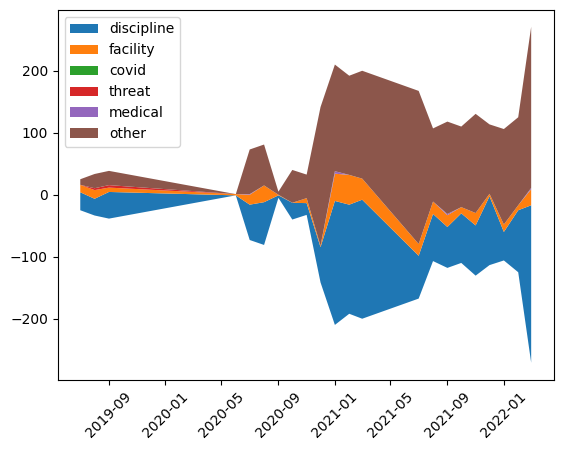

In [38]:
fig, ax = plt.subplots()

#grid = np.linspace(1985, 2025, num=500)
#y_smoothed = [gaussian_smooth(dates, y_, 1) for y_ in y]

#ax.stackplot(dates, y_smoothed, labels = ['disc', 'sec', 'c19', 'threat', 'medical', 'other' ], baseline = 'wiggle')
ax.stackplot(sums.date, sums.rsn_disciplinary_ind, sums.rsn_threat_facility_ind, sums.rsn_covid_ind, sums.rsn_threat_others_ind, sums.rsn_medical_ind, sums.rsn_other_ind, labels = ['discipline', 'facility', 'covid', 'threat', 'medical', 'other' ], baseline = 'sym')
ax.legend(loc='upper left')
plt.xticks(rotation = 45)
